In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from datetime import date
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import svm, kernel_ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option("display.max_rows", 100, "display.max_columns", 100)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

def p(s):
    print(s)
    
pd.DataFrame.len = pd.Index.len = lambda x: print(len(x))

In [2]:
# Partition training, dev, and test data
seasonHist = pd.read_csv('seasonHist.csv')
X = seasonHist \
    .loc[:,seasonHist.columns.str.contains('-\d+') | seasonHist.columns.str.match('fanPts')] \
    .drop('fanPts',axis=1) \
    .fillna(0)
y = seasonHist.fanPts

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_dev_raw, X_test_raw, y_dev, y_test = train_test_split(X_test_raw, y_test, test_size=0.5, random_state=0)

# Scale and normalize data
mms = preprocessing.MinMaxScaler()
X_train_scaled = mms.fit_transform(X_train_raw)
X_dev_scaled, X_test_scaled = mms.transform(X_dev_raw), mms.transform(X_test_raw)

ss = preprocessing.StandardScaler()
X_train_std = ss.fit_transform(X_train_raw)
X_dev_std, X_test_std = ss.transform(X_dev_raw), ss.transform(X_test_raw)

# Manually downselect useful columns
keepCols = \
    X.columns.str.contains('fanPts') | \
    X.columns.str.contains('^complete_pass') | \
    X.columns.str.contains('rush_attempt') | \
    X.columns.str.contains('yards_gained') | \
    X.columns.str.contains('^touchdown')

X_train_select, X_dev_select, X_test_select = X_train_raw.loc[:,keepCols], X_dev_raw.loc[:,keepCols], X_test_raw.loc[:,keepCols]

### Kernel Ridge Regression

#### Base models - various kernels

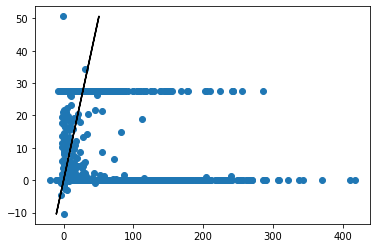

MAE: 49.8
RMSE: 78.7
R^2: -0.53


In [3]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev

m = kernel_ridge.KernelRidge(kernel='rbf')
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

plt.scatter(y_dev, y_pred)
plt.plot(y_pred,y_pred,color='black')
plt.show()

mae = mean_absolute_error(y_dev, y_pred).round(1)
rmse = mean_squared_error(y_dev, y_pred, squared=False).round(1)
r2 = r2_score(y_dev, y_pred).round(2)
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R^2: {r2}')

C:\Users\mrkawa\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=8.68019e-22): result may not be accurate.
  overwrite_a=False)


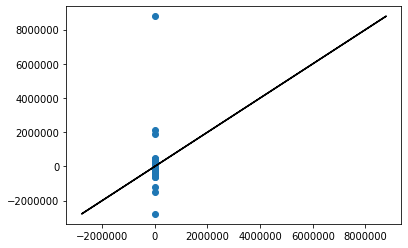

MAE: 28337.2
RMSE: 246096.3
R^2: -14911022.49


In [4]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev

m = kernel_ridge.KernelRidge(kernel='poly')
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

plt.scatter(y_dev, y_pred)
plt.plot(y_pred,y_pred,color='black')
plt.show()

mae = mean_absolute_error(y_dev, y_pred).round(1)
rmse = mean_squared_error(y_dev, y_pred, squared=False).round(1)
r2 = r2_score(y_dev, y_pred).round(2)
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R^2: {r2}')

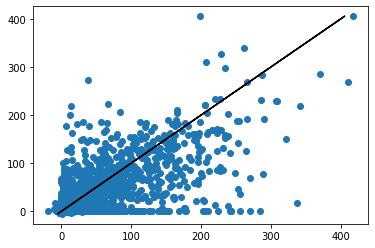

MAE: 29.9
RMSE: 50.4
R^2: 0.38


In [5]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev

m = kernel_ridge.KernelRidge(kernel='linear')
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

plt.scatter(y_dev, y_pred)
plt.plot(y_pred,y_pred,color='black')
plt.show()

mae = mean_absolute_error(y_dev, y_pred).round(1)
rmse = mean_squared_error(y_dev, y_pred, squared=False).round(1)
r2 = r2_score(y_dev, y_pred).round(2)
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R^2: {r2}')

#### Linear Kernel, GridSearchCV

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:   23.1s remaining:  2.5min
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:   27.7s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:   31.9s remaining:   47.9s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:   34.1s remaining:   29.8s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:   41.6s remaining:   20.7s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:   42.6s remaining:   10.6s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   53.5s finished


{'alpha': 100, 'kernel': 'linear'}


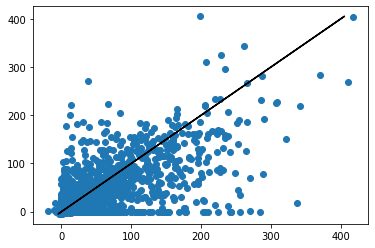

MAE: 29.9
RMSE: 50.3
R^2: 0.38


In [6]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev

grid = GridSearchCV(
    kernel_ridge.KernelRidge(),
    {
        'kernel':['linear'],
        'alpha':[10**x for x in range(-2,3)]
    },
    n_jobs = -1,
    verbose = 10,
    cv = 3
).fit(X_train,y_train)

print(grid.best_params_)

m = kernel_ridge.KernelRidge(**grid.best_params_)
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

plt.scatter(y_dev, y_pred)
plt.plot(y_pred,y_pred,color='black')
plt.show()

mae = mean_absolute_error(y_dev, y_pred).round(1)
rmse = mean_squared_error(y_dev, y_pred, squared=False).round(1)
r2 = r2_score(y_dev, y_pred).round(2)
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R^2: {r2}')

# pd.DataFrame(grid.cv_results_)[['param_alpha','mean_test_score','std_test_score','rank_test_score']]

#### Linear Kernel, GridSearchCV, hand-selected features

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:   15.6s remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:   17.1s remaining:   47.3s
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:   29.8s remaining:   44.7s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:   33.6s remaining:   29.4s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:   34.9s remaining:   17.4s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:   41.5s remaining:   10.3s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   45.0s finished


{'alpha': 100, 'kernel': 'linear'}


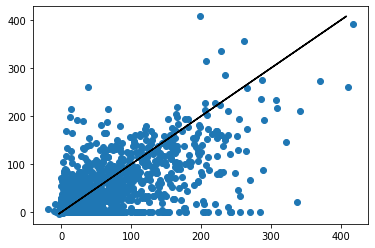

MAE: 29.7
RMSE: 50.2
R^2: 0.38


In [7]:
X_train, X_dev, y_train, y_dev = X_train_select, X_dev_select, y_train, y_dev

grid = GridSearchCV(
    kernel_ridge.KernelRidge(),
    {
        'kernel':['linear'],
        'alpha':[10**x for x in range(-2,3)]
    },
    n_jobs = -1,
    verbose = 10,
    cv = 3
).fit(X_train,y_train)

print(grid.best_params_)

m = kernel_ridge.KernelRidge(**grid.best_params_)
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

plt.scatter(y_dev, y_pred)
plt.plot(y_pred,y_pred,color='black')
plt.show()

mae = mean_absolute_error(y_dev, y_pred).round(1)
rmse = mean_squared_error(y_dev, y_pred, squared=False).round(1)
r2 = r2_score(y_dev, y_pred).round(2)
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R^2: {r2}')

# pd.DataFrame(grid.cv_results_)[['param_alpha','mean_test_score','std_test_score','rank_test_score']]